In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
%matplotlib inline

In [2]:
## Importing the necessary CSV files
wildFire_df   = pd.read_csv('wildfires_1996_2019.csv')
lightning_df  = pd.read_csv('Lightning.csv')
drought_df    = pd.read_csv('Drought_3.csv')
population_df = pd.read_csv('Population_Report.csv')
areaBurned_df = pd.read_csv('Wildfire_Area_Burned.csv')
sb_temp       = pd.read_csv('SanBernardinoTemp2.csv')
sd_temp       = pd.read_csv('SanDiegoTemp.csv')
rs_temp       = pd.read_csv('RiversideTemp2.csv')
wildFire_df.head()

,EVENT_ID,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,BEGIN_TIME,EVENT_TYPE,MAGNITUDE,TOR_F_SCALE,DEATHS_DIRECT,INJURIES_DIRECT,...,DEATHS_INDIRECT,SOURCE,FLOOD_CAUSE,TOR_LENGTH,TOR_WIDTH,BEGIN_RANGE,BEGIN_AZIMUTH,END_RANGE,END_AZIMUTH,END_LOCATION
0,5549398,VENTURA CO.,FILLMORE,4/28/1996,1400.0,Wildfire,NaN,NaN,0.0,2.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FILLMORE
1,5549399,RIVERSIDE CO.,RUBIDOUX,4/29/1996,900.0,Wildfire,NaN,NaN,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUBIDOUX
2,5545326,VENTURA CO.,FILLMORE,5/1/1996,0.0,Wildfire,NaN,NaN,0.0,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FILLMORE
3,5545327,RIVERSIDE CO.,RIVERSIDE,5/11/1996,1600.0,Wildfire,NaN,NaN,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RIVERSIDE
4,5575790,CALAVERAS CO.,T-C RANGER UNIT,8/12/1996,900.0,Wildfire,NaN,NaN,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T-C RANGER UNIT


## Preprocessing
---

We want to create a Serverity Index as our target for the classification algorthim. This Serverity Index will be based off of the Total Area Burned.
This data was obtained [here](https://www.fire.ca.gov/incidents/).

In [3]:
## Expanding out County Cell
areaBurned_df = areaBurned_df.assign(County=areaBurned_df['County'].str.split(';')).explode('County')
areaBurned_df['County'] = areaBurned_df['County'].str.lstrip()

In [4]:
areaBurned_df.describe(percentiles = [0.25, 0.50, 0.75, 0.90, 0.95])

,incident_acres_burned
count,1709.000000
mean,6584.052077
std,39171.201567
min,0.000000
25%,35.000000
50%,100.000000
75%,444.000000
90%,3901.800000
95%,16970.200000
max,410203.000000


I needed to combine the areaBurned dataframe with my drought dataframe. Unfortunatly the drought dataframe came with a start and end date. So I needed to create additional rows to accomadte the dates inbetween and forward fill them with their respectice D0, D1, ... D4 index given. Then I can combine this new datafram with the areaBurned by date and county. I could then match up the fires with when a drought was occuring. And match that with out custom Serverity Index.

In [5]:
## Temp File to Combine with Later
drought_temp = pd.read_csv('Drought_Updated.csv')

## Converting dates to datetime for fire merger
drought_temp['ValidStart'] = pd.to_datetime(drought_temp['ValidStart'])
drought_temp['ValidEnd']   = pd.to_datetime(drought_temp['ValidEnd'])
drought_df['Date']         = pd.to_datetime(drought_df['Date'])


## Forward filling the Dates
df_temp = pd.melt(drought_temp, id_vars='County', 
                  value_vars = ['ValidStart', 'ValidEnd'],
                  value_name='Date')
df_temp.Date = pd.to_datetime(df_temp.Date)
df_temp.set_index('Date', inplace=True)
df_temp.drop('variable', axis=1, inplace=True)

## Merging the dates together
df_temp = df_temp.groupby('County').resample('D').ffill().reset_index(level=0, drop=True).reset_index()

## index  Date         County  ##
## 101    2014-10-01   Alameda ##
## 102    2014-10-02   Alameda ##
## ...    ...          ...     ##
## 103    2014-10-01   Yuba    ##
## 104    2014-10-02   Yuba    ##  Why There are 148k Rows

drought_temp = pd.merge(df_temp, drought_df, on = ['County', 'Date'], how = 'outer')

cols = ['FIPS', 'None', 'D0', 'D1', 'D2', 'D3', 'D4']
drought_temp

,Date,County,FIPS,None,D0,D1,D2,D3,D4
0,2013-10-01,Alameda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-10-02,Alameda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-10-03,Alameda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-10-04,Alameda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-10-05,Alameda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
148591,2020-10-01,Yuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148592,2020-10-02,Yuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148593,2020-10-03,Yuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148594,2020-10-04,Yuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
## Converting Date to Datetime
areaBurned_df['Date'] = pd.to_datetime(areaBurned_df['Date'])

## Merging with Acreas Burned
df_merged = pd.merge(drought_temp, areaBurned_df, how = 'outer',
                     on = ['Date', 'County'])             ## Combine using outer       
df_merged = df_merged.sort_values(by=['Date','County'])   ## Sort by date and county
df_merged.loc[:,cols] = df_merged.loc[:,cols].ffill()     ## Fill Missing Values

df_merged.dropna() ## drop NaNs

,Date,County,FIPS,None,D0,D1,D2,D3,D4,incident_acres_burned
149399,2017-11-14,Riverside,6063.0,100.0,0.0,0.0,0.0,0.00,0.0,40.0
149289,2017-11-25,San Benito,6115.0,100.0,0.0,0.0,0.0,0.00,0.0,47.0
149254,2017-11-29,San Bernardino,6115.0,100.0,0.0,0.0,0.0,0.00,0.0,99.0
149398,2017-12-04,Riverside,6115.0,100.0,0.0,0.0,0.0,0.00,0.0,40.0
149017,2017-12-04,Santa Barbara,6115.0,100.0,0.0,0.0,0.0,0.00,0.0,281893.0
...,...,...,...,...,...,...,...,...,...,...
148612,2020-09-09,Yuba,6115.0,0.0,100.0,100.0,100.0,0.00,0.0,1311.0
148868,2020-09-11,Siskiyou,6115.0,0.0,100.0,100.0,100.0,0.00,0.0,50.0
149028,2020-09-16,Santa Barbara,6115.0,0.0,100.0,100.0,100.0,0.00,0.0,111.0
149444,2020-09-29,Riverside,6063.0,0.0,100.0,100.0,100.0,0.00,0.0,227.0


In [7]:
## Creating Serverity Index
serverity = [5 if i > 3894 else 4 if i > 448 
             else 3 if i > 100 else 2 if i > 35
             else 1 for i in df_merged.incident_acres_burned]

df_merged = df_merged.assign(serverity_index = serverity)
df_merged = df_merged.dropna()
print(df_merged['County'].nunique(), population_df['County'].nunique())

56 58


It works! Now we can repeat the above for the rest of the dataframes. (Wildfire, Lighting, and Population). Database for lighting is too small, so lets just leave it out.

### For Whatever reason, I cannot get the below cells to merge correctly
---

In [8]:
## Why won't this merge correctly...
population_df['County'] = population_df['County'].str.rstrip(' ')
df = pd.merge(df_merged, population_df[['County','Change 2010-19']], how = 'outer')
df

,Date,County,FIPS,None,D0,D1,D2,D3,D4,incident_acres_burned,serverity_index,Change 2010-19
0,2017-11-14,Riverside,6063.0,100.0,0.0,0.00,0.00,0.0,0.0,40.0,2.0,0.128
1,2017-12-04,Riverside,6115.0,100.0,0.0,0.00,0.00,0.0,0.0,40.0,2.0,0.128
2,2017-12-07,Riverside,6115.0,100.0,0.0,0.00,0.00,0.0,0.0,300.0,3.0,0.128
3,2017-12-13,Riverside,6115.0,100.0,0.0,0.00,0.00,0.0,0.0,19.0,1.0,0.128
4,2017-12-21,Riverside,6115.0,100.0,0.0,0.00,0.00,0.0,0.0,45.0,2.0,0.128
...,...,...,...,...,...,...,...,...,...,...,...,...
816,2020-08-14,Sierra,6115.0,0.0,100.0,100.00,72.59,0.0,0.0,47029.0,5.0,-0.072
817,2020-04-04,Imperial,6115.0,0.0,100.0,88.39,0.00,0.0,0.0,275.0,3.0,0.038
818,NaT,Alpine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.039
819,NaT,Del Norte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.028


In [9]:
## More Preprocessing... Yay!
wildFire_df[['CZ_FIPS', 'BEGIN_DATE']]

,CZ_FIPS,BEGIN_DATE
0,111.0,4/28/1996
1,65.0,4/29/1996
2,111.0,5/1/1996
3,65.0,5/11/1996
4,9.0,8/12/1996
...,...,...
1239,44.0,11/1/2019
1240,45.0,11/1/2019
1241,40.0,11/1/2019
1242,507.0,11/1/2019


In [10]:
## Tally Occurances
df_counts = pd.DataFrame(wildFire_df.groupby(['CZ_FIPS', 'BEGIN_DATE']).size()).reset_index()
df_counts.columns = ['Counts', 'Date', 'Occurance']

## Format Date
df_counts['Date'] = pd.to_datetime(df_counts['Date'])
df_counts

,Counts,Date,Occurance
0,3.0,2008-06-20,1
1,4.0,2008-06-20,1
2,4.0,2004-06-30,1
3,7.0,1999-10-15,1
4,7.0,1999-08-23,1
...,...,...,...
1092,547.0,2018-11-08,1
1093,547.0,2017-09-01,1
1094,548.0,2014-01-16,1
1095,552.0,2018-06-02,1


In [11]:
## Merged Wildfire Occurances
df_merged = pd.merge(df_merged, df_counts, how = 'outer')
pd.merge(df_merged, df_counts)

,Date,County,FIPS,None,D0,D1,D2,D3,D4,incident_acres_burned,serverity_index,Counts,Occurance
0,2017-12-04,Riverside,6115.0,100.0,0.0,0.0,0.0,0.0,0.0,40.0,2.0,39.0,1.0
1,2017-12-04,Santa Barbara,6115.0,100.0,0.0,0.0,0.0,0.0,0.0,281893.0,5.0,39.0,1.0
2,2017-12-04,Ventura,6115.0,100.0,0.0,0.0,0.0,0.0,0.0,281893.0,5.0,39.0,1.0
3,2017-12-04,Riverside,6115.0,100.0,0.0,0.0,0.0,0.0,0.0,40.0,2.0,40.0,1.0
4,2017-12-04,Santa Barbara,6115.0,100.0,0.0,0.0,0.0,0.0,0.0,281893.0,5.0,40.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376,2013-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,517.0,1.0
1377,2013-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,517.0,1.0
1378,2011-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,1.0
1379,2015-05-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,525.0,1.0


In [12]:
sd_temp['DATE'] = pd.to_datetime(sd_temp['DATE'])
sb_temp['DATE'] = pd.to_datetime(sb_temp['DATE'])
rs_temp['DATE'] = pd.to_datetime(rs_temp['DATE'])


In [13]:
sd_temp = sd_temp.drop(columns=['STATION', 'NAME'])
sb_temp = sb_temp.drop(columns=['STATION', 'NAME'])
rs_temp = rs_temp.drop(columns=['STATION', 'NAME'])
sd_temp.columns = ['Date', 'TMAX', 'TMIN', 'TAVG']
sb_temp.columns = ['Date', 'TAVG', 'TMAX', 'TMIN']
rs_temp.columns = ['Date', 'TAVG', 'TMAX', 'TMIN']

In [14]:
sd_wf = pd.merge(sd_temp, (df_counts.where(df_counts['Counts'] == 73.0)).dropna(), how = 'outer', on = 'Date').fillna(0)
sb_wf = pd.merge(sb_temp, (df_counts.where(df_counts['Counts'] == 71.0)).dropna(), how = 'outer', on = 'Date').fillna(0)
rs_wf = pd.merge(rs_temp, (df_counts.where(df_counts['Counts'] == 65.0)).dropna(), how = 'outer', on = 'Date').fillna(0)
fullmerge = pd.merge(sd_wf, pd.merge(sb_wf, rs_wf, how ='outer'), how = 'outer')

In [15]:
def plot_predicted(model, data):
    predicted = model.predict(data[['TMIN','TMAX']])
    correct = data[data['Occurance'] == predicted]
    correcta = correct[correct['Occurance'] == 0.0]
    correctb = correct[correct['Occurance'] == 1.0]
    incorrect = data[data['Occurance'] != predicted]
    incorrecta = incorrect[incorrect['Occurance'] == 1.0]
    incorrectb = incorrect[incorrect['Occurance'] == 0.0]
    
    plt.plot(correcta['TMIN'], correcta['TMAX'], 'b8', label='No Fire Days')
    plt.plot(incorrecta['TMIN'], incorrecta['TMAX'], 'b8', markerfacecolor='w', label='Predicted no Fire (incorrect)')
    plt.plot(incorrectb['TMIN'], incorrectb['TMAX'], 'r8', markerfacecolor='w', label='Predicted Fire (incorrect)')
    plt.plot(correctb['TMIN'], correctb['TMAX'], 'r^', label='Days with Fire')
    
def plot_boundary(model, data):
    cmap = mpl.colors.ListedColormap(['#FFFFFF','#FF8888'])
    xmin, xmax, ymin, ymax = 0, 110, 0, 110
    grid_size = 1
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))
    pp = model.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = np.array([{0:0,1:1}[ab] for ab in pp]) 
    zz = zz.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    plot_predicted(model, data)
    plt.legend(loc='upper left', ncol=1)

def plot_predicted_pop(model, data):
    predicted = model.predict(data[['Pop','TMAX']])
    correct = data[data['Occurance'] == predicted]
    correcta = correct[correct['Occurance'] == 0.0]
    correctb = correct[correct['Occurance'] == 1.0]
    incorrect = data[data['Occurance'] != predicted]
    incorrecta = incorrect[incorrect['Occurance'] == 1.0]
    incorrectb = incorrect[incorrect['Occurance'] == 0.0]
    
    plt.plot(correcta['Pop'], correcta['TMAX'], 'b8', label='No Fire Days')
    plt.plot(incorrecta['Pop'], incorrecta['TMAX'], 'b8', markerfacecolor='w', label='Predicted no Fire (incorrect)')
    plt.plot(incorrectb['Pop'], incorrectb['TMAX'], 'r8', markerfacecolor='w', label='Predicted Fire (incorrect)')
    plt.plot(correctb['Pop'], correctb['TMAX'], 'r^', label='Days with Fire')
    
def plot_boundary_pop(model, data):
    cmap = mpl.colors.ListedColormap(['#FFFFFF','#FF8888'])
    xmin, xmax, ymin, ymax = 0, 1, 0, 110
    grid_size = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))
    pp = model.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = np.array([{0:0,1:1}[ab] for ab in pp]) 
    zz = zz.reshape(xx.shape)
    
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    plt.xlabel("Population Normalized")
    plt.ylabel("Daily Max Temperature")
    plot_predicted_pop(model, data)
    
def plot_decision(model, data):
    cmap = 'coolwarm'
    xmin, xmax, ymin, ymax = 0, 100, 0, 100
    grid_size = 0.2
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))
    pp = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    zz = pp.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    plot_predicted(model, data)
    plt.xlabel("Daily Min Temperature")
    plt.ylabel("Daily Max Temperature")
    plt.ylim(20, ymax)
    plt.xlim(15, xmax)
    #plt.legend(loc='lower left', ncol=1, bbox_to_anchor=(0.45, 0.1))

In [16]:
#First we do San Bernardino
newdf = sb_wf.fillna(0)
newdf['Date'] = pd.to_datetime(newdf['Date'])
nofire = newdf[(newdf['Occurance'] == 0.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)].sample(frac=0.015)
fires  = newdf[(newdf['Occurance'] == 1.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)]
test = pd.merge(nofire, fires, how = 'outer')
test

,Date,TAVG,TMAX,TMIN,Counts,Occurance
0,1996-08-10,68,85,51,0.0,0.0
1,1998-03-25,36,42,30,0.0,0.0
2,2000-05-22,62,80,41,0.0,0.0
3,2014-02-05,30,48,16,0.0,0.0
4,1996-10-13,54,70,44,0.0,0.0
...,...,...,...,...,...,...
186,2003-10-21,55,82,36,71.0,1.0
187,2003-10-25,53,69,33,71.0,1.0
188,2007-06-23,63,82,43,71.0,1.0
189,2019-08-24,65,80,47,71.0,1.0


In [17]:
# Build a modle on sb's data
from sklearn import svm

model = svm.SVC(kernel='linear', C=100)
model.fit(test[['TMIN',  'TMAX']], test['Occurance'])

SVC(C=100, kernel='linear')

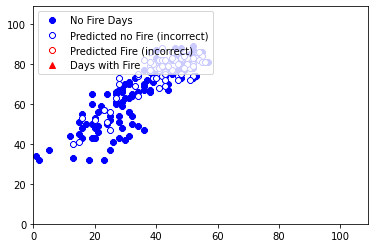

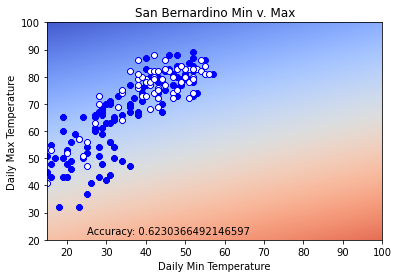

In [18]:
plot_boundary(model, test)
plot_decision(model, test)
plt.text(25, 22.0, s="Accuracy: " + str(model.score(test[['TMIN', 'TMAX']], test['Occurance'])))
plt.title("San Bernardino Min v. Max")
plt.savefig("San Bernardino T.png")
plt.show()


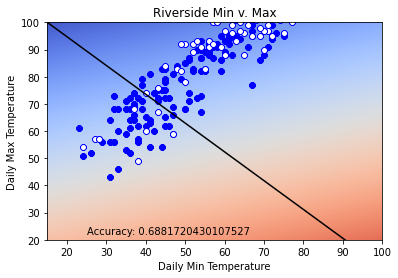

In [19]:
# Now we go for Riverside
newdf = rs_wf.fillna(0)
newdf['Date'] = pd.to_datetime(newdf['Date'])
nofire = newdf[(newdf['Occurance'] == 0.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)].sample(frac=0.015)
fires  = newdf[(newdf['Occurance'] == 1.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)]
test = pd.merge(nofire, fires, how = 'outer')

plot_decision(model, test)
plt.title("Riverside Min v. Max")
plt.text(25, 22.0, s="Accuracy: " + str(model.score(test[['TMIN', 'TMAX']], test['Occurance'])))
plt.plot([15, 100], [100, 10], 'k-')
plt.savefig("Riverside T.png")

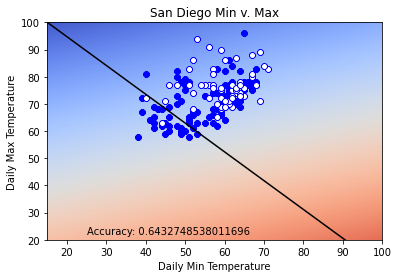

In [20]:
# Then San Diego
newdf = sd_wf.fillna(0)
newdf['Date'] = pd.to_datetime(newdf['Date'])
nofire = newdf[(newdf['Occurance'] == 0.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)].sample(frac=0.015)
fires  = newdf[(newdf['Occurance'] == 1.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)]
test = pd.merge(nofire, fires, how = 'outer')

plot_decision(model, test)
plt.title("San Diego Min v. Max")
plt.text(25, 22.0, s="Accuracy: " + str(model.score(test[['TMIN', 'TMAX']], test['Occurance'])))
plt.plot([15, 100], [100, 10], 'k-')
plt.savefig("San Diego T.png")

Text(25, 22.0, 'Accuracy: 0.6130536130536131')

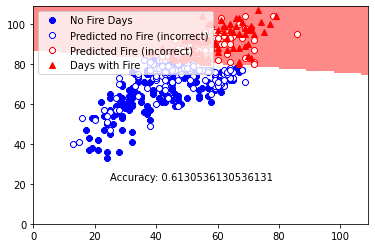

In [21]:
newdf = fullmerge.fillna(0)
newdf['Date'] = pd.to_datetime(newdf['Date'])
nofire = newdf[(newdf['Occurance'] == 0.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)].sample(frac=0.010)
fires  = newdf[(newdf['Occurance'] == 1.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)]
test = pd.merge(nofire, fires, how = 'outer')

model = svm.SVC(kernel='linear', C=100)
model.fit(test[['TMIN',  'TMAX']], test['Occurance'])

plot_boundary(model, test)
plt.text(25, 22.0, s="Accuracy: " + str(model.score(test[['TMIN', 'TMAX']], test['Occurance'])))

Text(25, 22.0, 'Accuracy: 0.6432748538011696')

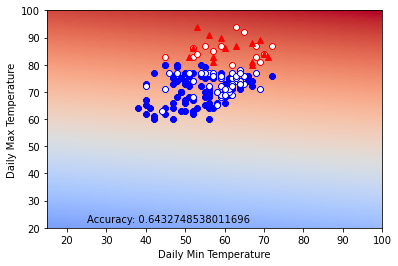

In [22]:
newdf = sd_wf.fillna(0)
newdf['Date'] = pd.to_datetime(newdf['Date'])
nofire = newdf[(newdf['Occurance'] == 0.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)].sample(frac=0.015)
fires  = newdf[(newdf['Occurance'] == 1.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)]
test = pd.merge(nofire, fires, how = 'outer')

plot_decision(model, test)
plt.text(25, 22.0, s="Accuracy: " + str(model.score(test[['TMIN', 'TMAX']], test['Occurance'])))


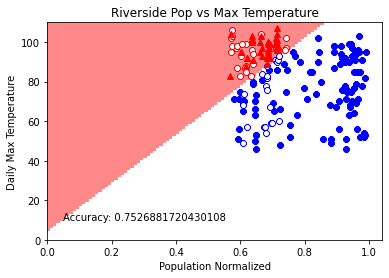

In [23]:
pop = population_df[(population_df['County'] == 'San Diego') | 
              (population_df['County'] == 'San Bernardino') | 
              (population_df['County'] == 'Riverside')]
# Construct Population for each date
pop_rs_90 = range(pop.loc[32][1], pop.loc[32][2], int((pop.loc[32][2] - pop.loc[32][1])/3652))
pop_rs_00 = range(pop.loc[32][2], pop.loc[32][3], int((pop.loc[32][3] - pop.loc[32][2])/3653))
pop_rs_10 = range(pop.loc[32][3], pop.loc[32][4], int((pop.loc[32][4] - pop.loc[32][3])/3652))
pop_rs = list(pop_rs_90)[2282:] + list(pop_rs_00) + list(pop_rs_10)
norm = [float(i)/max(pop_rs) for i in pop_rs]
rs_wf['Pop'] = pd.Series(norm)
rs_wf = rs_wf.dropna()
newdf = rs_wf.fillna(0)
newdf['Date'] = pd.to_datetime(newdf['Date'])
nofire = newdf[(newdf['Occurance'] == 0.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)].sample(frac=0.015)
fires  = newdf[(newdf['Occurance'] == 1.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)]
test = pd.merge(nofire, fires, how = 'outer')
model = svm.SVC(kernel='linear', C=100)
model.fit(test[['Pop',  'TMAX']], test['Occurance'])
plot_boundary_pop(model, test)
plt.text(0.05, 10.0, s="Accuracy: " + str(model.score(test[['Pop',  'TMAX']], test['Occurance'])))
plt.title("Riverside Pop vs Max Temperature")
plt.savefig("RSPT")

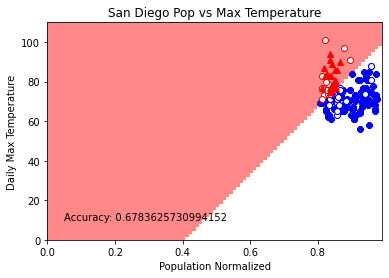

In [24]:
pop_sd_90 = range(pop.loc[36][1], pop.loc[36][2], int((pop.loc[36][2] - pop.loc[36][1])/3652))
pop_sd_00 = range(pop.loc[36][2], pop.loc[36][3], int((pop.loc[36][3] - pop.loc[36][2])/3653))
pop_sd_10 = range(pop.loc[36][3], pop.loc[36][4], int((pop.loc[36][4] - pop.loc[36][3])/3652))
pop_sd = list(pop_sd_90)[2282:] + list(pop_sd_00) + list(pop_sd_10)
norm = [float(i)/max(pop_sd) for i in pop_sd]
sd_wf['Pop'] = pd.Series(norm)
sd_wf = sd_wf.dropna()
newdf = sd_wf.fillna(0)
newdf['Date'] = pd.to_datetime(newdf['Date'])
nofire = newdf[(newdf['Occurance'] == 0.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)].sample(frac=0.015)
fires  = newdf[(newdf['Occurance'] == 1.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)]
test = pd.merge(nofire, fires, how = 'outer')
test
model = svm.SVC(kernel='linear', C=100)
model.fit(test[['Pop',  'TMAX']], test['Occurance'])
plot_boundary_pop(model, test)
plt.text(0.05, 10.0, s="Accuracy: " + str(model.score(test[['Pop',  'TMAX']], test['Occurance'])))
plt.title("San Diego Pop vs Max Temperature")
plt.savefig("SDPT")

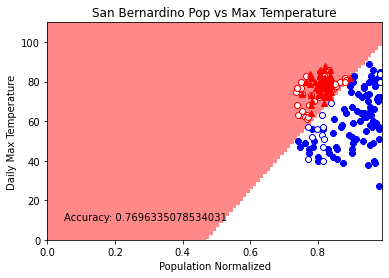

In [25]:
pop_sb_90 = range(pop.loc[35][1], pop.loc[35][2], int((pop.loc[35][2] - pop.loc[35][1])/3652))
pop_sb_00 = range(pop.loc[35][2], pop.loc[35][3], int((pop.loc[35][3] - pop.loc[35][2])/3653))
pop_sb_10 = range(pop.loc[35][3], pop.loc[35][4], int((pop.loc[35][4] - pop.loc[35][3])/3652))
pop_sb = list(pop_sb_90)[2282:] + list(pop_sb_00) + list(pop_sb_10)
norm = [float(i)/max(pop_sb) for i in pop_sb]
sb_wf['Pop'] = pd.Series(norm)
sb_wf = sb_wf.dropna()
newdf = sb_wf.fillna(0)
newdf['Date'] = pd.to_datetime(newdf['Date'])
nofire = newdf[(newdf['Occurance'] == 0.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)].sample(frac=0.015)
fires  = newdf[(newdf['Occurance'] == 1.0) & (newdf['TAVG'] != 0.0) & (newdf['TMAX'] != 0)]
test = pd.merge(nofire, fires, how = 'outer')
test
model = svm.SVC(kernel='linear', C=100)
model.fit(test[['Pop',  'TMAX']], test['Occurance'])
plot_boundary_pop(model, test)
plt.text(0.05, 10.0, s="Accuracy: " + str(model.score(test[['Pop',  'TMAX']], test['Occurance'])))
plt.title("San Bernardino Pop vs Max Temperature")
plt.savefig("SBPT")

## Starting Classification! Supervised Learning
---

In [ ]:
## Determing Inputs and Targets
inputs = ['None', 'D0', 'D1', 'D2', 'D3', 'D4', 'incident_acres_burned']
target = ['serverity_index']
df_merged[inputs].dropna()

In [ ]:
## Scatter Plot of two Features
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize = (15,5))

for i in df_merged['serverity_index'].dropna().unique():
    label = int(i)                                                       ## Servertiy Index
    plt.scatter(df_merged[df_merged['serverity_index'] == i]['D1'], ## Plot All Points where Serverity 
                df_merged[df_merged['serverity_index'] == i]['D2'], ## is the same value
                label = f'Serverity {label}')  ## Label Points
    
plt.legend()
plt.show()

## Note:
## Normalize Acres Burned
## Skipping for now

In [ ]:
## PCA Transformation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Applying principle component
pca = PCA(n_components = 3)
pca.fit(df_merged[inputs].dropna())

## Applying Transformation
df_pca = pca.transform(df_merged[inputs].dropna())

In [ ]:
# Functions to analyize each value of K

## Creating and Fitting the model object
km = KMeans(5) ## Step 1
km.fit(df_pca) ## Step 2

## Predicting Cluster Assignments
clusters = km.predict(df_pca) ## Step 3
    
## Create subplots 
fig, ax = plt.subplots(figsize = (15,5))

## Generating scatter plots
for i in np.unique(clusters):
    ax.scatter(df_pca[clusters == i, 0], ## Plots the points where cluster == classification
               df_pca[clusters == i, 1]) ## in the 0th and 1st column of data points 
            
## Formatting Plots to look pretty
plt.title('KMeans 5')
plt.xlabel('Feature Space 1')
plt.ylabel('Feature Space 2')

plt.show()

In [ ]:
inputs = ['TAVG', 'TMAX', 'TMIN', 'Pop']
target = ['Occurance']

In [ ]:
pca = PCA(n_components = 3)
pca.fit(test[inputs].dropna())

## Applying Transformation
df_pca = pca.transform(test[inputs].dropna())

In [ ]:
km = KMeans(2) ## Step 1
km.fit(df_pca) ## Step 2

## Predicting Cluster Assignments
clusters = km.predict(df_pca) ## Step 3
    
## Create subplots 
fig, ax = plt.subplots(figsize = (15,5))

## Generating scatter plots
for i in np.unique(clusters):
    ax.scatter(df_pca[clusters == i, 0], ## Plots the points where cluster == classification
               df_pca[clusters == i, 1]) ## in the 0th and 1st column of data points 
            
## Formatting Plots to look pretty
plt.title('KMeans 5')
plt.xlabel('Feature Space 1')
plt.ylabel('Feature Space 2')

plt.show()

In [63]:
sd_wf

,Date,TMAX,TMIN,TAVG,Counts,Occurance,Pop
0,1996-04-01,70.0,47.0,59.0,0.0,0.0,0.807079
1,1996-04-02,68.0,57.0,63.0,0.0,0.0,0.807105
2,1996-04-03,66.0,50.0,58.0,0.0,0.0,0.807131
3,1996-04-04,70.0,53.0,62.0,0.0,0.0,0.807156
4,1996-04-05,85.0,51.0,68.0,0.0,0.0,0.807182
...,...,...,...,...,...,...,...
7441,2003-08-10,0.0,0.0,0.0,73.0,1.0,0.974555
7442,2003-08-27,0.0,0.0,0.0,73.0,1.0,0.974575
7443,2003-08-04,0.0,0.0,0.0,73.0,1.0,0.974595
7444,1999-09-28,0.0,0.0,0.0,73.0,1.0,0.974615


In [96]:
t = pd.merge(sd_wf[sd_wf['Occurance'] == 1.0], 
             (df_merged
                     .drop(columns=['Occurance'])
                     .where((df_counts['Counts'] == 71.0) 
                    )).dropna(),
             how = 'outer', 
             on = 'Date').fillna(0)
t


,Date,TMAX,TMIN,TAVG,Counts_x,Occurance,Pop,County,FIPS,None,D0,D1,D2,D3,D4,incident_acres_burned,serverity_index,Counts_y
0,1996-10-21,77.0,51.0,64.0,73.0,1.0,0.812154,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1997-08-01,87.0,63.0,75.0,73.0,1.0,0.819264,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1997-09-25,83.0,71.0,77.0,73.0,1.0,0.820655,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1998-08-31,84.0,70.0,77.0,73.0,1.0,0.826890,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1999-06-27,68.0,59.0,64.0,73.0,1.0,0.834361,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2019-09-07,0.0,0.0,0.0,0.0,0.0,0.000000,Siskiyou,6115.0,100.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0,66.0
120,2019-09-07,0.0,0.0,0.0,0.0,0.0,0.000000,Siskiyou,6115.0,100.0,0.0,0.0,0.0,0.0,0.0,227.0,3.0,66.0
121,2019-09-07,0.0,0.0,0.0,0.0,0.0,0.000000,Siskiyou,6115.0,100.0,0.0,0.0,0.0,0.0,0.0,1872.0,4.0,66.0
122,2019-09-07,0.0,0.0,0.0,0.0,0.0,0.000000,Trinity,6115.0,100.0,0.0,0.0,0.0,0.0,0.0,280.0,3.0,66.0


In [109]:
from sklearn import svm
features_names = ['TMAX', 'TMIN', 'TAVG']
nsvm = svm.SVC(kernel='linear')
nsvm.fit(test[features_names], test['Occurance'])

SVC(kernel='linear')

['TMAX', 'TMIN', 'TAVG'] [0.02003895 0.02505966 0.04031498]


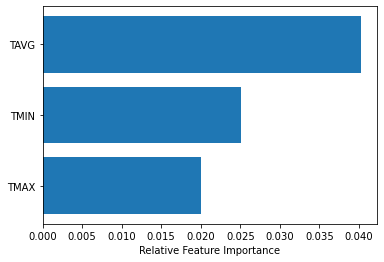

In [111]:
def f_importances(coef, names):
    imp = coef[0]
    print(names,imp)
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.xlabel("Relative Feature Importance")
    plt.savefig("FImp")
    plt.show()
    
f_importances(nsvm.coef_, features_names)


### Looks Promising, Lets break it down by County

In [ ]:
df_merged['County'].unique().shape
## Should Have 58, It's close enough
## Could be due to missing data or no data for those counties
## Missing Alpine, Del Norte, San Francisco, Why do I have MEXICO!

In [ ]:
np.unique(df_merged['FIPS'].dropna()).shape
#That is weird

In [ ]:
counties = np.unique(df_merged['County'].dropna())

In [ ]:
## Cycling Through Each County!
for i in counties: 
    df_county = df_merged.query(f'County == "{i}"') ## Dimensionality Crisis!
    
    if(df_county.shape[0] > 5): ## Pew... Crisis Averted!
        
        ## Applying principle component
        pca = PCA(n_components = 3)
        pca.fit(df_county[list(inputs)])

        ## Applying Transformation
        df_pca = pca.transform(df_county[list(inputs)])
        
        ## Creating and Fitting the model object
        km = KMeans(5) ## Step 1
        km.fit(df_pca) ## Step 2

        ## Predicting Cluster Assignments
        clusters = km.predict(df_pca) ## Step 3
        
        ## Now that I have the clusters, I can make a small heat Map!
        ## Could try forward filling the dates to show a time lapse
        df_test = df_county.assign(rank = clusters)
        
    

## I have the Clusters, Time to Draw a Heat Map
---
We would need to take a snapshot at a certain time. To do this, we need to forward fill the dates. Stopping here for now.

In [ ]:
import seaborn as sns
import shapefile as shp
########################################################################
# you might need to run "conda install pyshp" from anaconda cmd prompt #
########################################################################
plt.style.use('ggplot')

# Load in California County Map
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))
shp_path = '../../CA_Counties/CA_Counties_TIGER2016.shp'
sf = shp.Reader(shp_path)

In [ ]:
def plot_map_fill_multiples_ids(title, comuna, sf, x_lim = None, y_lim = None, figsize = (11,9), color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for index, id in enumerate(comuna):
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color[index])
             
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        plt.text(x0, y0, id, fontsize=10)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        
# Fills in counties with slect color

comuna_id = [0, 1, 2, 7, 40, 41]
colors = ['r', 'g', 'y', 'b', '#b0b074', 'black']
plot_map_fill_multiples_ids("For example", 
                            comuna_id, sf, color = colors)